In [1]:
import numpy as np
import time
import utils
import matplotlib.pyplot as plt
from task2a import cross_entropy_loss, SoftmaxModel, one_hot_encode, pre_process_images
from trainer import BaseTrainer
np.random.seed(0)

In [2]:
def calculate_accuracy(X: np.ndarray, targets: np.ndarray, model: SoftmaxModel) -> float:
    """
    Args:
        X: images of shape [batch size, 785]
        targets: labels/targets of each image of shape: [batch size, 10]
        model: model of class SoftmaxModel
    Returns:
        Accuracy (float)
    """
    outputs = model.forward(X)
    predictions = one_hot_encode(np.argmax(outputs, axis=1), targets.shape[1])
    accuracy = np.sum(predictions * targets) / targets.shape[0]
    return accuracy


In [3]:
class SoftmaxTrainer(BaseTrainer):

    def __init__(
            self,
            momentum_gamma: float,
            use_momentum: bool,
            *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.momentum_gamma = momentum_gamma
        self.use_momentum = use_momentum
        # Init a history of previous gradients to use for implementing momentum
        self.previous_grads = [np.zeros_like(w) for w in self.model.ws]

    def train_step(self, X_batch: np.ndarray, Y_batch: np.ndarray):
        """
        Perform forward, backward and gradient descent step here.
        The function is called once for every batch (see trainer.py) to perform the train step.
        The function returns the mean loss value which is then automatically logged in our variable self.train_history.

        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        # TODO: Implement this function (task 2c)        
        outputs = self.model.forward(X_batch)
        self.model.backward(X = X_batch, outputs = outputs, targets = Y_batch)
        
        for i in range(len(self.model.ws)):
            if self.use_momentum:
                delta_w = self.model.grads[i] + momentum_gamma * self.previous_grads[i]
                self.model.ws[i] -= self.learning_rate * delta_w
                self.previous_grads[i] = delta_w   
            else :
                self.model.ws[i] -= self.learning_rate * self.model.grads[i]
                 
        loss = cross_entropy_loss(Y_batch, outputs)  # sol

        return loss

    def validation_step(self):
        """
        Perform a validation step to evaluate the model at the current step for the validation set.
        Also calculates the current accuracy of the model on the train set.
        Returns:
            loss (float): cross entropy loss over the whole dataset
            accuracy_ (float): accuracy over the whole dataset
        Returns:
            loss value (float) on batch
            accuracy_train (float): Accuracy on train dataset
            accuracy_val (float): Accuracy on the validation dataset
        """
        # NO NEED TO CHANGE THIS FUNCTION
        logits = self.model.forward(self.X_val)
        loss = cross_entropy_loss(self.Y_val, logits)

        accuracy_train = calculate_accuracy(
            self.X_train, self.Y_train, self.model)
        accuracy_val = calculate_accuracy(
            self.X_val, self.Y_val, self.model)
        return loss, accuracy_train, accuracy_val




Train shape: X: (20000, 784), Y: (20000, 1)
Validation shape: X: (10000, 784), Y: (10000, 1)
Initializing weight to shape: (785, 32)
Initializing weight to shape: (32, 10)
Early stopping at epoch 15
Final Train Cross Entropy Loss: 0.023674279542052694
Final Validation Cross Entropy Loss: 0.2283861674469696
Train accuracy: 0.99475
Validation accuracy: 0.947
--- 13.012584924697876 seconds ---


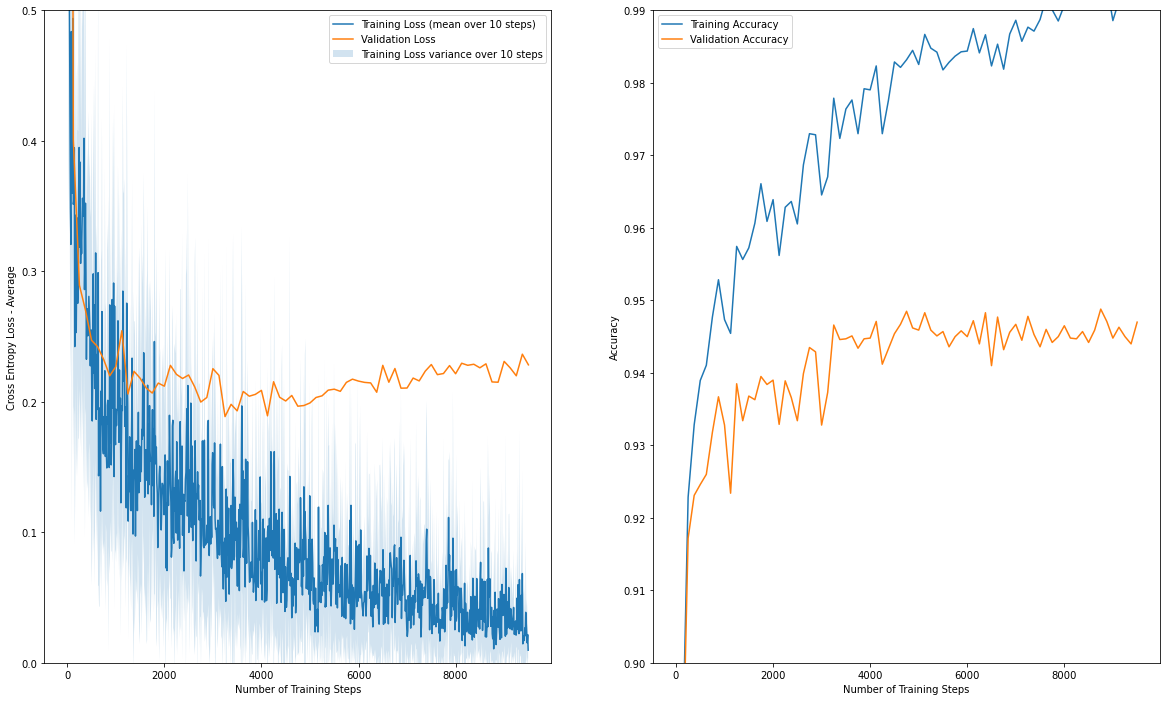

In [5]:
if __name__ == "__main__":
    # hyperparameters DO NOT CHANGE IF NOT SPECIFIED IN ASSIGNMENT TEXT
    start_time = time.time()
    num_epochs = 50
    learning_rate = .02
    batch_size = 32
    neurons_per_layer = [32, 10]
    momentum_gamma = .9  # Task 3 hyperparameter
    shuffle_data = True

    # Settings for task 3. Keep all to false for task 2.
    use_improved_sigmoid = True
    use_improved_weight_init = True
    use_momentum = True
    
    if use_momentum == False:
        learning_rate = .1
    
    
    # Load dataset
    X_train, Y_train, X_val, Y_val = utils.load_full_mnist()
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = pre_process_images(X_train, mean, std)
    X_val = pre_process_images(X_val, mean, std)
    Y_train = one_hot_encode(Y_train, 10)
    Y_val = one_hot_encode(Y_val, 10)
    # Hyperparameters

    model = SoftmaxModel(
        neurons_per_layer,
        use_improved_sigmoid,
        use_improved_weight_init)
    trainer = SoftmaxTrainer(
        momentum_gamma, use_momentum,
        model, learning_rate, batch_size, shuffle_data,
        X_train, Y_train, X_val, Y_val,
    )
    train_history, val_history = trainer.train(num_epochs)

    print("Final Train Cross Entropy Loss:",
          cross_entropy_loss(Y_train, model.forward(X_train)))
    print("Final Validation Cross Entropy Loss:",
          cross_entropy_loss(Y_val, model.forward(X_val)))
    print("Train accuracy:", calculate_accuracy(X_train, Y_train, model))
    print("Validation accuracy:", calculate_accuracy(X_val, Y_val, model))
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Plot loss for first model (task 2c)
    plt.figure(figsize=(20, 12))
    plt.subplot(1, 2, 1)
    plt.ylim([0., .5])
    utils.plot_loss(train_history["loss"],
                    "Training Loss", npoints_to_average=10)
    utils.plot_loss(val_history["loss"], "Validation Loss")
    plt.legend()
    plt.xlabel("Number of Training Steps")
    plt.ylabel("Cross Entropy Loss - Average")
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.ylim([0.90, .99])
    utils.plot_loss(train_history["accuracy"], "Training Accuracy")
    utils.plot_loss(val_history["accuracy"], "Validation Accuracy")
    plt.xlabel("Number of Training Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("task2c_train_loss.png")